A demonstration of non-parametric outlier detection techniques

In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
from scipy import stats
import time
from numpy.linalg import inv
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

VERBOSE = True

Define a function to identify outliers using Tukey's boxplot method.

The method is very simple:

We define InterQuartile Range as: $IQR = Q3-Q1; $

Then $Whiskers = (Q3 + \beta * IQR, Q1 - \beta * IQR)$.  Then points outside $Whiskers$ are outliers. The "magic number" for $\beta$ is $1.5$

This method can be extended to accommodate the subject-matter experts' knowledge: for example, if we know that the lowest possible value of a data point cannot be negative, we can force the lower whisker never to drop below $0$; similarly, if we know that we are dealing with a distribution of probabilities, we know that the upper whisker cannot be higher than $1$.

The function **IdentifyBoxplotWhiskers** below computes the whiskers and allows the user to set the *lowest_possible* and *highest_possible* values.

In [2]:
def IdentifyBoxplotWhiskers (myvector, beta = 1.5, lowest_possible = None, highest_possible = None):
    pctls = np.percentile(myvector, q= (25, 75))
    if VERBOSE:    print pctls
    iqr = pctls[1] - pctls[0]
    if VERBOSE:    print iqr
    whiskers = [(pctls[0] - beta * iqr), (pctls[1] + beta * iqr)]
    if lowest_possible is not None:
        whiskers[0] = max (whiskers[0], lowest_possible)
    if highest_possible is not None:
        whiskers[1] = min (whiskers[1], highest_possible)
    return whiskers


def IdentifyOutlierIndices (myvector, beta = 1.5, lowest_possible = None, highest_possible = None):
  whiskers = IdentifyBoxplotWhiskers(myvector, beta, lowest_possible, highest_possible)
  if VERBOSE:    print whiskers

  hi_ol_indices = np.where(myvector > whiskers[1])
  lo_ol_indices = np.where(myvector < whiskers[0])

  olIndices = np.hstack((hi_ol_indices, lo_ol_indices))
  return olIndices


Generate a bunch of random numbers and call the function defined above

(1050,)
[  3.1097196   14.44799197]
11.3382723692
[0.0, 31.455400518843]
Found 52 outliers


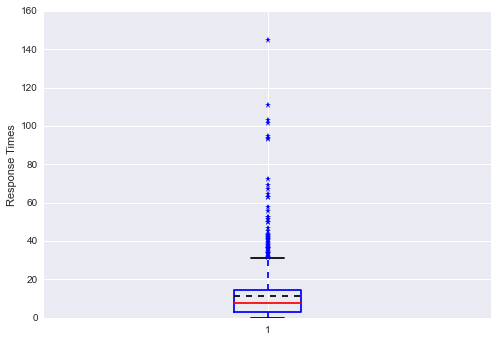

In [3]:
np.random.seed(1234567890)
thedata = np.random.exponential(10, 1000)
outliers = np.random.exponential(30, 50)

mydata = np.hstack((thedata, outliers))
print mydata.shape
mydata_outliers = IdentifyOutlierIndices(mydata, 1.5, 0.0)
print "Found %d outliers" % (mydata_outliers.shape[1])

plt.boxplot(x=mydata, sym='*', vert=True,manage_xticks=True, meanline = True, showmeans=True)
plt.ylabel("Response Times")
plt.show()

How will it work with a pair of linearly correlated variables?

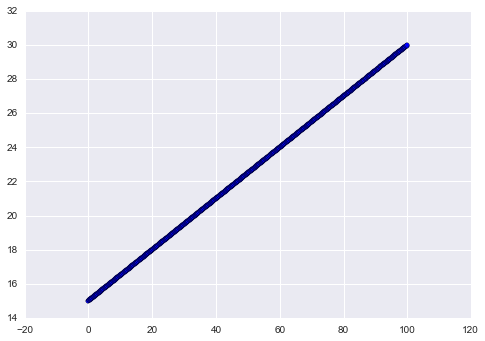

In [6]:
############################################################################################################
X = np.arange (0, 100, 0.1)
#print X.shape

Y = 15 + 0.15*X
#print Y.shape

plt.scatter (X, Y)
plt.show()

A regression through these data is trivial and not interesting.  Let's "Make Some Noise"

In [7]:

Yblur = np.random.exponential(10, X.shape[0])
Y_fuzzy = Y + Yblur

##  Some numpy-required manipulations here
X_regr =X[:, np.newaxis]
Y_regr = Y_fuzzy[:, np.newaxis]
print X_regr.__class__
print Y_regr.__class__

##  And now let's fit the LinearRegression
lr = LinearRegression()
lr.fit(X_regr, Y_regr)

print "LinearRegression: ", lr
print "Y = %.3f * X + %.3f" %(lr.coef_[0], lr.intercept_)

print "Regression RSq:", lr.score(X_regr, Y_regr)
pred = lr.predict(X_regr)


<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
LinearRegression:  LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
Y = 0.152 * X + 24.468
Regression RSq: 0.159920742106


Why is the RSq so bad? Plot the noisy data with the regression line

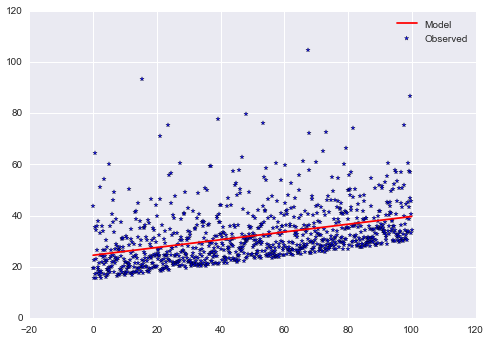

In [8]:
plt.plot(X_regr, pred, color = 'red', label="Model")
plt.pcolor='r'
plt.scatter(X_regr, Y_regr, cmap='b', label="Observed", marker='*')
plt.legend(loc='best')
plt.show()


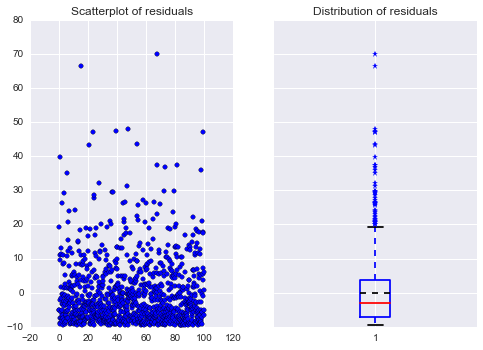

In [9]:
#######################################################################
##  Graphically Analyze Residuals:
#######################################################################
myResid = Y_regr - pred
#print myResid.shape
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True)
ax1 = axes[0]
ax2 = axes[1]
ax1.scatter(X_regr, myResid)
ax2.boxplot (x=myResid, sym='*', vert=True,manage_xticks=True, meanline = True, showmeans=True)
ax1.set_title("Scatterplot of residuals")
ax2.set_title("Distribution of residuals")
plt.show()

We see that:

(1) Residuals are independent of X - this is good news: it means we've got the right $Y(X)$ relationship.

(2) Residuals are not normally distributed - this is bad news: it means we've chosen the wrong model for prediction.

Let's try to build a 95% confidence interval for the residuals.  We know that for a normal distribution, 95% confidence corresponds to +/- 3 $\sigma$

The 95-pct CI for residuals = +/- 30.101


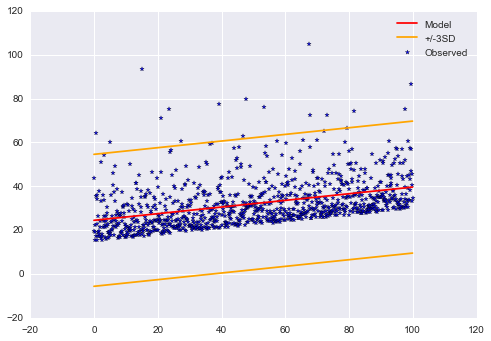

In [10]:
resid_3sd = 3*np.std(myResid)

## The lines corresponding to the 3-sigma confidence interval will be:
plus3SD = pred + resid_3sd
minus3SD = pred - resid_3sd
print "The 95-pct CI for residuals = +/- %.3f" %(resid_3sd)

## Now rebuild the scatter plot with the regression line, adding the confidence interval:
plt.plot(X_regr, pred, color = 'red', label="Model")
plt.scatter(X_regr, Y_regr, cmap='b', label="Observed", marker='*')
plt.plot(X_regr, plus3SD, '-', color = "orange", label = "+/-3SD")
plt.plot(X_regr, minus3SD, '-', color = "orange")

plt.legend(loc='best')
plt.show()

This is a nonsensical result: we know that the data cannot be below zero: we built it to be above the $Y = 15 + 0.15*X$ line, and yet we cannot say with 95% confidence that it will not happen, especially at low values of X. 

We need to redefine the confidence interval if we are dealing with non-normally distributed data.  One - very convenient - solution comes from the boxplot: we can define confidence intervals as whiskers of the boxplot.  

    Downside: we will not know the "p-value".
    Upside:  we'll be able to draw the outlier boundary lines
        (and p-value is overrated, anyway).

In [11]:
myResidWhiskers = IdentifyBoxplotWhiskers(myResid)
print myResidWhiskers

[-7.01928518  3.76154304]
10.7808282183
[-23.190527505039604, 19.93278536829731]


Outlier Boundaries on Residuals =  [-23.190527505039604, 19.93278536829731]
The 95-pct CI for residuals = +/- 30.101


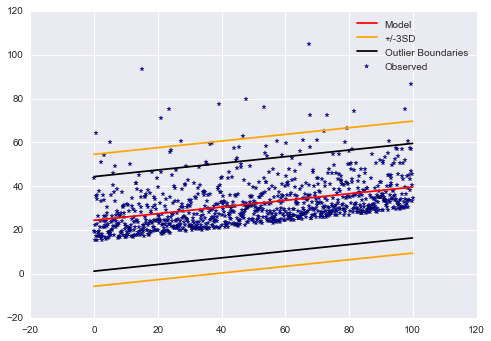

In [12]:
loBound = pred + myResidWhiskers[0]
hiBound = pred + myResidWhiskers[1]

print "Outlier Boundaries on Residuals = ", myResidWhiskers

print "The 95-pct CI for residuals = +/- %.3f" %(resid_3sd)

## Now rebuild the scatter plot with the regression line, adding the confidence interval:
plt.plot(X_regr, pred, color = 'red', label="Model")
plt.scatter(X_regr, Y_regr, cmap='b', label="Observed", marker='*')
plt.plot(X_regr, plus3SD, '-', color = "orange", label = "+/-3SD")
plt.plot(X_regr, minus3SD, '-', color = "orange")
plt.plot(X_regr, loBound, '-', color = "black", label = "Outlier Boundaries")
plt.plot(X_regr, hiBound, '-', color = "black")

plt.legend(loc='best')
plt.show()

Now looking at the outlier boundaries (the black lines in the plot above), we see that any value of $Y$ that happens to be negative will be an outlier.

If we know that the lowest value of *myResid* is the lowest possible value, we can force the outlier boundary never to cross that line (***BE VERY CAUTIOUS WHEN MAKING SUCH DECISION***).  For the scenario we are looking into, the modified outlier boundaries will be shown in the plot below:

[-9.59315477]
Outlier Boundaries on Residuals =  [array([-9.59315477]), 19.93278536829731]
The 95-pct CI for residuals = +/- 30.101


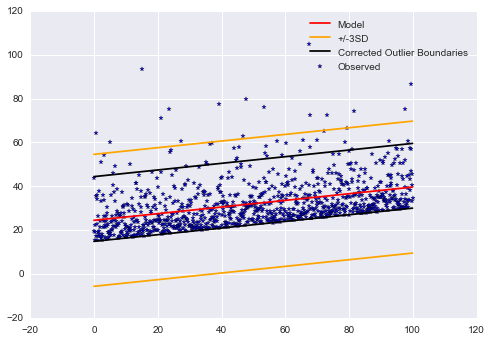

In [13]:
## Check min(myResid) and set the low whisker to its value if it is < minresid:
minresid = min(myResid)
print minresid
if myResidWhiskers[0] < minresid:
    myResidWhiskers[0] = minresid
    
## Predict the low and high boundaries:
loBound = pred + myResidWhiskers[0]
hiBound = pred + myResidWhiskers[1]

print "Outlier Boundaries on Residuals = ", myResidWhiskers

print "The 95-pct CI for residuals = +/- %.3f" %(resid_3sd)

## Now rebuild the scatter plot with the regression line, adding the confidence interval:
plt.plot(X_regr, pred, color = 'red', label="Model")
plt.scatter(X_regr, Y_regr, cmap='b', label="Observed", marker='*')
plt.plot(X_regr, plus3SD, '-', color = "orange", label = "+/-3SD")
plt.plot(X_regr, minus3SD, '-', color = "orange")
plt.plot(X_regr, loBound, '-', color = "black", label = "Corrected Outlier Boundaries")
plt.plot(X_regr, hiBound, '-', color = "black")

plt.legend(loc='best')
plt.show()

Now the outlier boundaries reflect the true nature of the data.

This methodology does not have to be limited to a straight line (or a "flat" hyperplane) describing the dependency of $Y$ and $X$: it works equally well for any polynomial, exponential, hyperbolic, and most importantly for ML, sigmoid lines.  However, it will only work when the residuals are independent of the $X$.

When residuals of a linear regression are correlated with $X$, or when different quantiles of $Y$ have a different regression of $X$, we cannot use this approach.  **Quantile Regression** becomes the preferred model.  An unexpected benefit of using Quantile Regression is that we can compute the predictions of the 25th and 75th percentiles (first and third quartiles), applying then Tukey's method in order to directly (without figuring out the distribution of the outliers) build predictions of the outlier boundaries.